Name : Afaan Ansari

UICD : 2019230064

Batch : C 

Sub : FCI

# Detection of Emoji using facial expression

emotional recognition with the help of facial expressions. Today is the era of fast and dynamic internet and communication technologies. Hence, the communication is more convenient as compared to the past. Use of communications through different channels, such as mobile phones and computers, are very common in today’s era. E-mails, text messaging, blog entries, and comments are some of the forms of communication which are very common today. To enhance the experience of communication, emojis were developed . Emoji’s are the pictorial representation of the facial expression of human beings. They are very helpful in the facilitation of human emotional experiences.

The Facial  emoji  recognizer detects  the  expression  of  the  person and converts that expression of the person into the emoji of 7 classes .  We implement a classifier for face detection of  CNN algorithm for expression  detection .


Dataset link [Facial expression](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data)

Github link [
Emoji-detection-using-facial-expression](https://github.com/affan00733/Emoji-detection-using-facial-expression)

load the required modules

In [76]:
import pandas as pd
import numpy as np
from keras.models import load_model
import os.path
import cv2
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras import callbacks
from keras.callbacks import EarlyStopping
from keras.layers import MaxPool2D
from keras.layers import Conv2D,MaxPooling2D
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16
from keras.initializers import glorot_normal,glorot_uniform, he_normal, he_uniform
from keras.optimizers import Adamax,Adam, Adadelta, Adagrad, RMSprop, Nadam, SGD
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.regularizers import l2,l1
from keras.callbacks import ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')

here is the type of the emoji's that we are going to classify , we classifing it into 7 categories

In [77]:
emoji = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']
# 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

Now we are reading the dataset csv file which is combind of training , validation and test set . and we have columns emotion which is output label , usage which gives the type of set and despite of giving the images it gives the image cell values which is pixel column

In [78]:
data = pd.read_csv("/kaggle/input/face-data-1/icml_face_data.csv")
data.columns = ['emotion', 'Usage', 'pixels']

here we are visulaizing the dataset in dataframe

In [79]:
data

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...,...
35882,6,PrivateTest,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883,3,PrivateTest,178 174 172 173 181 188 191 194 196 199 200 20...
35884,0,PrivateTest,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885,3,PrivateTest,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...


In [80]:
data["Usage"].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

now we have created the prepare data function here we are transforming the image pixels cell data into the format which is accepted by the neural network model which is row , columns , channes is 48 , 48 , 1 respectively . to transform it into 48x48 we are reshaping it and also dividing it by 255 as it is an image

In [81]:
def prepare_data(data):
    image_array = np.zeros(shape=(len(data), 48, 48, 1))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48)) 
        image_array[i, :, :, 0] = image / 255

    return image_array, image_label

now we are showing the distribution of  training , validation and test set

In [82]:
full_train_images, full_train_labels = prepare_data(data[data['Usage']=='Training'])
val_images, val_labels = prepare_data(data[data['Usage']=='PublicTest'])
test_images, test_labels = prepare_data(data[data['Usage']=='PrivateTest'])

print(full_train_images.shape)
print(full_train_labels.shape)
print(val_images.shape)
print(val_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(28709, 48, 48, 1)
(28709,)
(3589, 48, 48, 1)
(3589,)
(3589, 48, 48, 1)
(3589,)


As to give the output Y label to the model we need to categorize it And we are categoring the training , validation and test set

In [83]:
y_train_ohe = to_categorical(full_train_labels, num_classes=7)
y_val_ohe = to_categorical(val_labels, num_classes=7)
y_test_ohe = to_categorical(test_labels, num_classes=7)

In [84]:
print(y_train_ohe.shape)
print(y_val_ohe.shape)
print(y_test_ohe.shape)

(28709, 7)
(3589, 7)
(3589, 7)


number of image rows and columns

In [85]:
img_rows=48
img_cols=48

now we are defing the model and doing the hyper-parameter tuning . we are making a block of  CNN model where first 4 blocks is of the convolution layer and other remaining 3 blocks is of fully connected layer . And in each convolution block there is pair of convolution layer which is going from 32 , 64 , 128, 256 and filter of size 3x3 . Also we are using relu activation function for non-linearinty . as we are using blocks of convolution layer so we need to use batch normalization so they can be normalized into same scale . Also we are using the max pooling layer of pool size 2x2 and dropout rate of 20% for convolution layer blocks

And in the fully connected layer blocks first we are using the flatten layer so the input can be normalized and reshaped into the output format . Here also we are using relu activation function and batch normalization which has same purpose as above and we are changing the dropout rate to 50% . And conecting it to dense layer and at the last layer we are giveing the softmax activation function because it is multiclass prediction .

In [86]:
model = Sequential()

# Block-1

model.add(Conv2D(32,(3,3),padding='same',input_shape=(img_rows,img_cols,1)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),padding='same',input_shape=(img_rows,img_cols,1)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block-2 

model.add(Conv2D(64,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block-3

model.add(Conv2D(128,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block-4 

model.add(Conv2D(256,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block-5

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block-6

model.add(Dense(64))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block-7

model.add(Dense(7))
model.add(Activation('softmax'))

print(model.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
activation_11 (Activation)   (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
activation_12 (Activation)   (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 32)       

The more hyperparameters are model checkpoints which  saves the model in every epochs which has the best result by monitoring the validation loss . Early stopping stops the model automatically is validation loss doesn't improves at the rate of 3 epochs and at last we are adding the reduce LR Plateau whcih helps to dynamically changing the learning rate , here we are monitoring the validation loss at rate of 3 epochs.
And we using the categorical crossentropy as loss function as it is categorical classification , Adam optimizer we are using because it gives the momentum Also is takes long step from left to right and small step from top to bottom.

In [87]:
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint('emoji.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks = [earlystop,checkpoint,reduce_lr]

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])



Then we are training the model by giving training set and validation and giving callbacks and maximum 100 epochs

In [88]:
hist = model.fit(full_train_images, y_train_ohe, epochs=100, verbose=1,
          validation_data=(val_images, y_val_ohe), shuffle=True, callbacks=callbacks)



Epoch 1/100
898/898 [==============================] - 39s 41ms/step - loss: 2.3590 - accuracy: 0.1951 - val_loss: 1.6481 - val_accuracy: 0.3335

Epoch 00001: val_loss improved from inf to 1.64806, saving model to emoji.h5
Epoch 2/100
898/898 [==============================] - 37s 41ms/step - loss: 1.6708 - accuracy: 0.3370 - val_loss: 1.3970 - val_accuracy: 0.4536

Epoch 00002: val_loss improved from 1.64806 to 1.39699, saving model to emoji.h5
Epoch 3/100
898/898 [==============================] - 37s 41ms/step - loss: 1.4428 - accuracy: 0.4411 - val_loss: 1.3036 - val_accuracy: 0.4921

Epoch 00003: val_loss improved from 1.39699 to 1.30358, saving model to emoji.h5
Epoch 4/100
898/898 [==============================] - 37s 41ms/step - loss: 1.3514 - accuracy: 0.4869 - val_loss: 1.2315 - val_accuracy: 0.5227

Epoch 00004: val_loss improved from 1.30358 to 1.23154, saving model to emoji.h5
Epoch 5/100
898/898 [==============================] - 37s 41ms/step - loss: 1.2546 - accuracy: 

now we evaluating the model by test set which gives the 63 % accuracy

In [89]:
# training loss and accuracy
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
print('Training Accuracy: ', train_acc[-1])
print('Validation Accuracy: ', val_acc[-1])

# test loss and accuracy
score, acc = model.evaluate(test_images, y_test_ohe)
print('Test score:', score)
print('Test accuracy:', acc)

Training Accuracy:  0.7219687104225159
Validation Accuracy:  0.630259096622467
113/113 [==============================] - 4s 32ms/step - loss: 0.9804 - accuracy: 0.6305
Test score: 0.9803521037101746
Test accuracy: 0.630537748336792


now by visualiztion we can see that the gap between training and validation accuracy and training and validation loss is less in the below graph so it is not overfitting

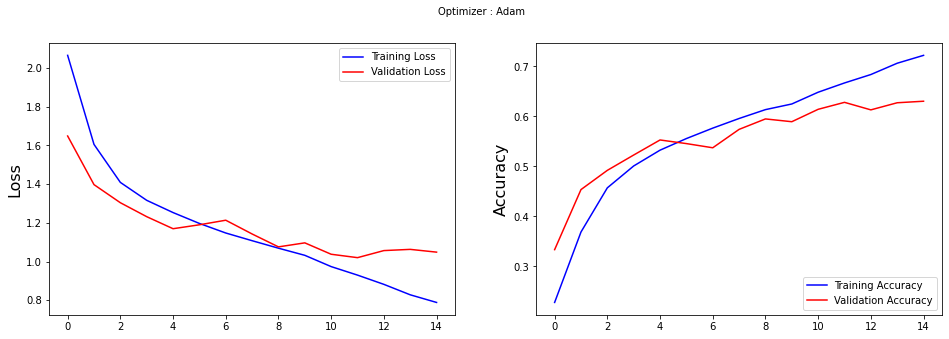

In [90]:

plt.figure(figsize=(16,5))
# training loss graph
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color='b', label='Training Loss')
plt.plot(hist.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

# training accuracy graph
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

Now we predicting the output emojis in test set

In [91]:
test_res = model.predict(test_images)

In [92]:
test_res = np.argmax(test_res,axis=1)

Transforming output label to emojis in tes tset

In [93]:
res_final = pd.DataFrame()
res_final["pixels"] = data["pixels"][data['Usage']=='PrivateTest']
res_final["emoji"] = test_res
res_final.loc[res_final.emoji == 0, "emoji"] = "😡"
res_final.loc[res_final.emoji == 1, "emoji"] = "🤢"
res_final.loc[res_final.emoji == 2, "emoji"] = "😰"
res_final.loc[res_final.emoji == 3, "emoji"] = "😁"
res_final.loc[res_final.emoji == 4, "emoji"] = "😥"
res_final.loc[res_final.emoji == 5, "emoji"] = "😱"
res_final.loc[res_final.emoji == 6, "emoji"] = "😀"
res_final = res_final.reset_index()

Visulaizing the emojis in test set as dataframe

In [94]:
res_final

,index,pixels,emoji
0,32298,170 118 101 88 88 75 78 82 66 74 68 59 63 64 6...,😡
1,32299,7 5 8 6 7 3 2 6 5 4 4 5 7 5 5 5 6 7 7 7 10 10 ...,😥
2,32300,232 240 241 239 237 235 246 117 24 24 22 13 12...,😰
3,32301,200 197 149 139 156 89 111 58 62 95 113 117 11...,😥
4,32302,40 28 33 56 45 33 31 78 152 194 200 186 196 20...,😱
...,...,...,...
3584,35882,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,😀
3585,35883,178 174 172 173 181 188 191 194 196 199 200 20...,😁
3586,35884,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,😥
3587,35885,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,😁


Transforming output label to emojis in validation set


In [96]:
val_test = pd.DataFrame()
val_test = data[data['Usage']=='PublicTest']
val_test.loc[val_test.emotion == 0, "emoji"] = "😡"
val_test.loc[val_test.emotion == 1, "emoji"] = "🤢"
val_test.loc[val_test.emotion == 2, "emoji"] = "😰"
val_test.loc[val_test.emotion == 3, "emoji"] = "😁"
val_test.loc[val_test.emotion == 4, "emoji"] = "😥"
val_test.loc[val_test.emotion == 5, "emoji"] = "😱"
val_test.loc[val_test.emotion == 6, "emoji"] = "😀"
val_test = val_test.reset_index()

Visulaizing the emojis in validation set as dataframe

In [97]:
val_test

,index,emotion,Usage,pixels,emoji
0,28709,0,PublicTest,254 254 254 254 254 249 255 160 2 58 53 70 77 ...,😡
1,28710,1,PublicTest,156 184 198 202 204 207 210 212 213 214 215 21...,🤢
2,28711,4,PublicTest,69 118 61 60 96 121 103 87 103 88 70 90 115 12...,😥
3,28712,6,PublicTest,205 203 236 157 83 158 120 116 94 86 155 180 2...,😀
4,28713,3,PublicTest,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...,😁
...,...,...,...,...,...
3584,32293,4,PublicTest,178 176 172 173 173 174 176 173 166 166 206 22...,😥
3585,32294,3,PublicTest,25 34 42 44 42 47 57 59 59 58 54 51 50 56 63 6...,😁
3586,32295,4,PublicTest,255 255 255 255 255 255 255 255 255 255 255 25...,😥
3587,32296,4,PublicTest,33 25 31 36 36 42 69 103 132 163 175 183 187 1...,😥


Transforming output label to emojis in training set


In [98]:
training = pd.DataFrame()
training = data[data['Usage']=='Training']
training.loc[training.emotion == 0, "emoji"] = "😡"
training.loc[training.emotion == 1, "emoji"] = "🤢"
training.loc[training.emotion == 2, "emoji"] = "😰"
training.loc[training.emotion == 3, "emoji"] = "😁"
training.loc[training.emotion == 4, "emoji"] = "😥"
training.loc[training.emotion == 5, "emoji"] = "😱"
training.loc[training.emotion == 6, "emoji"] = "😀"
training = training.reset_index()

Visulaizing the emojis in training set as dataframe

In [99]:
training

,index,emotion,Usage,pixels,emoji
0,0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,😡
1,1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...,😡
2,2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...,😰
3,3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,😥
4,4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,😀
...,...,...,...,...,...
28704,28704,2,Training,84 85 85 85 85 85 85 85 86 86 86 87 86 86 91 9...,😰
28705,28705,0,Training,114 112 113 113 111 111 112 113 115 113 114 11...,😡
28706,28706,4,Training,74 81 87 89 95 100 98 93 105 120 127 133 146 1...,😥
28707,28707,0,Training,222 227 203 90 86 90 84 77 94 87 99 119 134 14...,😡


Now we are defing the function so we can see the images and the predicted emojis for the training , validationa and test set

In [100]:
def predict_training(index):
    print(training.emoji[index])
    plt.imshow(full_train_images[index])

In [101]:
def predict_validation(index):
    print(val_test.emoji[index])
    plt.imshow(val_images[index])

In [102]:
def predict_test(index):
    print(res_final.emoji[index])
    plt.imshow(test_images[index])

predicted emoji for training which is sad face emoji

😥


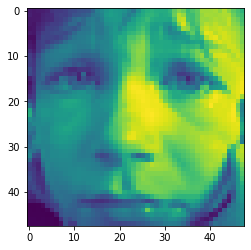

In [107]:
predict_training(6)

predicted emoji for validation which is happy face emoji

😁


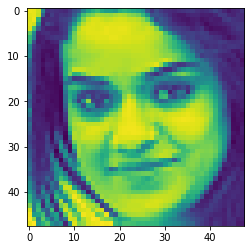

In [108]:
predict_validation(5)

predicted emoji for test which is shocking face emoji

😱


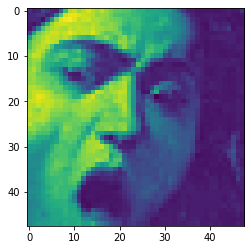

In [109]:
predict_test(4)

# Conclusion
* In this project we have done Emoji detection using facial expression
* We have made a block of CNN model which the input we have transpormed into 48 , 48 , 1 . where 48 is rows and columns and 1 is channel.
* The result we get from this model is 71% training accuracy , 64% validation accuracy anf 63% testing accuracy
* The hyper-parameter tuning we have used is model checkpoints for saving best model , eary stopping for automatically stopping the model if it is not improving and reduceLR for dynamically changing learning rate
* The above shown graph we can see the gap between training and validation accuracy and training and validation loss is less so it is not overfitting
* There are some images of training , validation and testing are shown above with their emojis by comparison we can see that we are getting promising result